<a href="https://colab.research.google.com/github/chbigbrother/tensorflow/blob/master/%EC%8B%A4%EC%8A%B5_2_%EB%B0%B0%ED%8F%AC%EC%9A%A9_dnn_bike_demand_regression_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DNN(MLP) 모델을 이용한 자전거 대여 수요 예측 데이터 셋 회귀 분석-1  
* 단일 값(`count`) 예측 모델 구현

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models

### Step 1-1. Input tensor 와 Target tensor 준비(훈련데이터)
* 자전거 수요 예측 데이터셋 파일 down

In [ ]:
auto_mpg_dataset_url = "https://drive.google.com/uc?export=download&id=1WhSZll5tDUUl3sFLJMIO01a0d2tQtfc7"
dataset_path = tf.keras.utils.get_file("/content/bike-demand.csv", auto_mpg_dataset_url)
dataset_path

655360/648353 [==============================] - 0s 0us/step


'/content/bike-demand.csv'

*  데이터 셋 파일을 읽어 Dataframe 객체 생성

In [ ]:
raw_dataset = pd.read_csv('/content/bike-demand.csv')
dataset = raw_dataset.copy()

* 데이터셋의 info 확인

In [ ]:
# type here 1
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   count       10886 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 765.5 KB


### Step 1-2. 입력 데이터의 전처리 
* 데이터 셋 내의 NaN 값 체크

In [ ]:
# type here 2
dataset.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

* 학습에 사용하지 않을 컬럼 정보 제거
  * `datetime` : 데이터의 식별 정보(모든 데이터가 unique)
  * `casual` : 직접적인 수요 정보(현장 대여 수요)
  * `registered` : 직접적인 수요 정보(예약 대여 수요)

In [ ]:
# type here 3
drop_columns = ['datetime', 'casual', 'registered']
dataset.drop(drop_columns, axis=1, inplace=True)

* 데이터셋 에서 20% 선택하여 test 데이터 셋으로 분할

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

8709
2177


* 표준화를 통한 Input tensor의 전처리  
  * 수치형 특성 정보에 대해서만 표준화 수행  

In [ ]:
# category 데이터와 numerical 데이터의 분류
numeric_column = ['temp',	'atemp',	'humidity',	'windspeed']

In [ ]:
# 데이터 전처리를 위한 통계정보 생성
# type here 4
train_stats = train_dataset[numeric_column].describe()

In [ ]:
train_stats

,temp,atemp,humidity,windspeed
count,8709.000000,8709.000000,8709.000000,8709.000000
mean,20.269978,23.698172,62.016535,12.839881
std,7.801503,8.493468,19.266975,8.139981
min,0.820000,0.760000,0.000000,0.000000
25%,13.940000,16.665000,47.000000,7.001500
50%,20.500000,24.240000,62.000000,12.998000
75%,26.240000,31.060000,78.000000,16.997900
max,41.000000,45.455000,100.000000,56.996900


In [ ]:
# 각 특성 별 통계정보를 가공하기 쉽도록 matrix 전치
train_stats = train_stats.transpose()

In [ ]:
train_stats

,count,mean,std,min,25%,50%,75%,max
temp,8709.0,20.269978,7.801503,0.82,13.9400,20.500,26.2400,41.0000
atemp,8709.0,23.698172,8.493468,0.76,16.6650,24.240,31.0600,45.4550
humidity,8709.0,62.016535,19.266975,0.00,47.0000,62.000,78.0000,100.0000
windspeed,8709.0,12.839881,8.139981,0.00,7.0015,12.998,16.9979,56.9969


In [ ]:
# Target tensor 를 위한 자전거 대여 수요(count) 추출
# type here 5
#train_labels = train_dataset.pop('count')
test_labels = test_dataset.pop('count')

In [ ]:
train_dataset

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6638,1,0,1,1,23.78,27.275,56,7.0015
7975,2,0,1,2,27.06,29.545,89,19.0012
5915,1,0,1,1,18.86,22.725,55,19.0012
8050,2,0,1,1,28.70,31.820,42,11.0014
5894,1,0,1,1,22.14,25.760,52,19.0012
...,...,...,...,...,...,...,...,...
3372,3,0,1,1,32.80,36.365,43,15.0013
7954,2,0,1,2,31.16,34.090,48,22.0028
232,1,0,1,1,5.74,7.575,59,11.0014
968,1,0,1,1,13.12,15.150,61,16.9979


In [ ]:
# Input tensor의 표준화(평균 :0/ 표준편차 :1) 함수 정의
# type here 6
def norm(x):
  normed_data = (x - train_stats['mean']) / train_stats['std']
  return normed_data

In [ ]:
# 수치형 Input tensor 들만 특성 정보 표준화 처리 수행
# type here 7
train_dataset[numeric_column] = norm(train_dataset[numeric_column])
test_dataset[numeric_column] = norm(test_dataset[numeric_column])

In [ ]:
train_dataset.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,8709.000000,8709.000000,8709.000000,8709.000000,8.709000e+03,8.709000e+03,8.709000e+03,8.709000e+03
mean,2.507636,0.028476,0.677575,1.417844,-9.026592e-15,-1.690678e-15,-5.885750e-17,-2.637010e-14
std,1.115553,0.166339,0.467432,0.634745,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,0.000000,0.000000,1.000000,-2.493107e+00,-2.700684e+00,-3.218800e+00,-1.577385e+00
25%,2.000000,0.000000,0.000000,1.000000,-8.113793e-01,-8.280684e-01,-7.793925e-01,-7.172475e-01
50%,3.000000,0.000000,1.000000,1.000000,2.948429e-02,6.379350e-02,-8.581845e-04,1.942497e-02
75%,4.000000,0.000000,1.000000,2.000000,7.652399e-01,8.667635e-01,8.295784e-01,5.108143e-01
max,4.000000,1.000000,1.000000,4.000000,2.657183e+00,2.561595e+00,1.971429e+00,5.424708e+00


### Step 2. DNN(MLP) 모델 디자인

In [ ]:
#type here 8
model = models.Sequential()
model.add(layers.Dense(units=64, activation='relu', input_shape=(len(train_dataset.keys()),)))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,689
Trainable params: 2,689
Non-trainable params: 0
_________________________________________________________________


### Step 3. 모델의 학습 정보 설정

In [ ]:
# type here 9
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

### Step 4. 모델에 input, target 데이터 연결 후 학습

In [ ]:
# validation data set percent : 20%
# type here 10
history = model.fit(
    x=train_dataset, y=train_labels,
    batch_size=16,
    epochs=100,
    validation_split=0.2
)


Epoch 1/100
436/436 [==============================] - 0s 1ms/step - loss: 43978.4570 - mae: 146.7446 - val_loss: 27863.6211 - val_mae: 124.9415
Epoch 2/100
436/436 [==============================] - 0s 695us/step - loss: 24570.1211 - mae: 117.4905 - val_loss: 26860.2832 - val_mae: 121.4959
Epoch 3/100
436/436 [==============================] - 0s 740us/step - loss: 23976.3477 - mae: 115.3188 - val_loss: 26679.8418 - val_mae: 120.1518
Epoch 4/100
436/436 [==============================] - 0s 721us/step - loss: 23842.5215 - mae: 114.9971 - val_loss: 26566.5703 - val_mae: 118.5995
Epoch 5/100
436/436 [==============================] - 0s 721us/step - loss: 23763.7578 - mae: 114.3739 - val_loss: 26569.3867 - val_mae: 120.5421
Epoch 6/100
436/436 [==============================] - 0s 695us/step - loss: 23689.7305 - mae: 114.4879 - val_loss: 26406.2090 - val_mae: 118.8494
Epoch 7/100
436/436 [==============================] - 0s 720us/step - loss: 23625.9277 - mae: 114.2689 - val_loss: 2635

### Step 5. 학습 과정 시각화  
  *  학습 이력 정보에서 학습 데이터에 대한 'mae'/ 검증 데이터에 대한 'mae'를 추출하여 하나의 차트로 시각화
  *  학습 이력 정보에서 학습 데이터에 대한 'loss'/ 검증 데이터에 대한 'loss'를 추출하여 하나의 차트로 시각화

In [ ]:
# 학습과정 시각화를 위한 정보 추출
loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history['mae']
val_mae = history.history['val_mae']

In [ ]:
# 차트의 x 축을 위한 epoch 정보 생성
epochs = range(1, len(loss)+1)

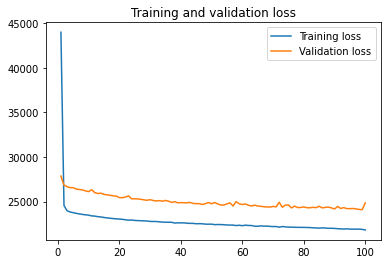

In [ ]:
# loss 정보 시각화
# type here 11
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

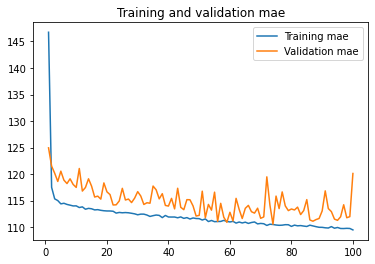

In [ ]:
# Mean Absolute Error 정보 시각화
# type here 12
plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

### Step 6. 테스트 데이터 셋을 통한 모델의 성능 평가

In [ ]:
# 테스트 데이터 셋을 통한 성능 측정
# type here 13
test_loss, test_mae = model.evaluate(x=test_dataset, y=test_labels)

69/69 [==============================] - 0s 550us/step - loss: 23007.6562 - mae: 116.7056


### Step 7. 학습된 모델을 이용한 특정 데이터의 예측  
  *  테스트 데이터 중 100건 데이터의 예측 결과 출력  


In [ ]:
#type here 14
predictions = model.predict(test_dataset[:100])

  *  테스트 정답 데이터 100건 추출하여 모델의 예측결과와 비교하여 차트로 시각화

In [ ]:
index = range(1, len(predictions) + 1)

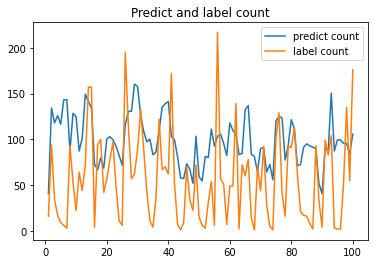

In [ ]:
# 정답 데이터와 예측 데이터 정보 시각화
plt.plot(index, predictions, label='predict count')
plt.plot(index, test_labels[:len(predictions)], label='label count')
plt.title('Predict and label count')
plt.legend()

plt.show()